# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Download the CIFAR-100 dataset (train and test)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders - BATCH SIZE IS SUBJECTIVE TO CHANGE 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Check the data
images, labels = next(iter(trainloader))

Files already downloaded and verified
Files already downloaded and verified


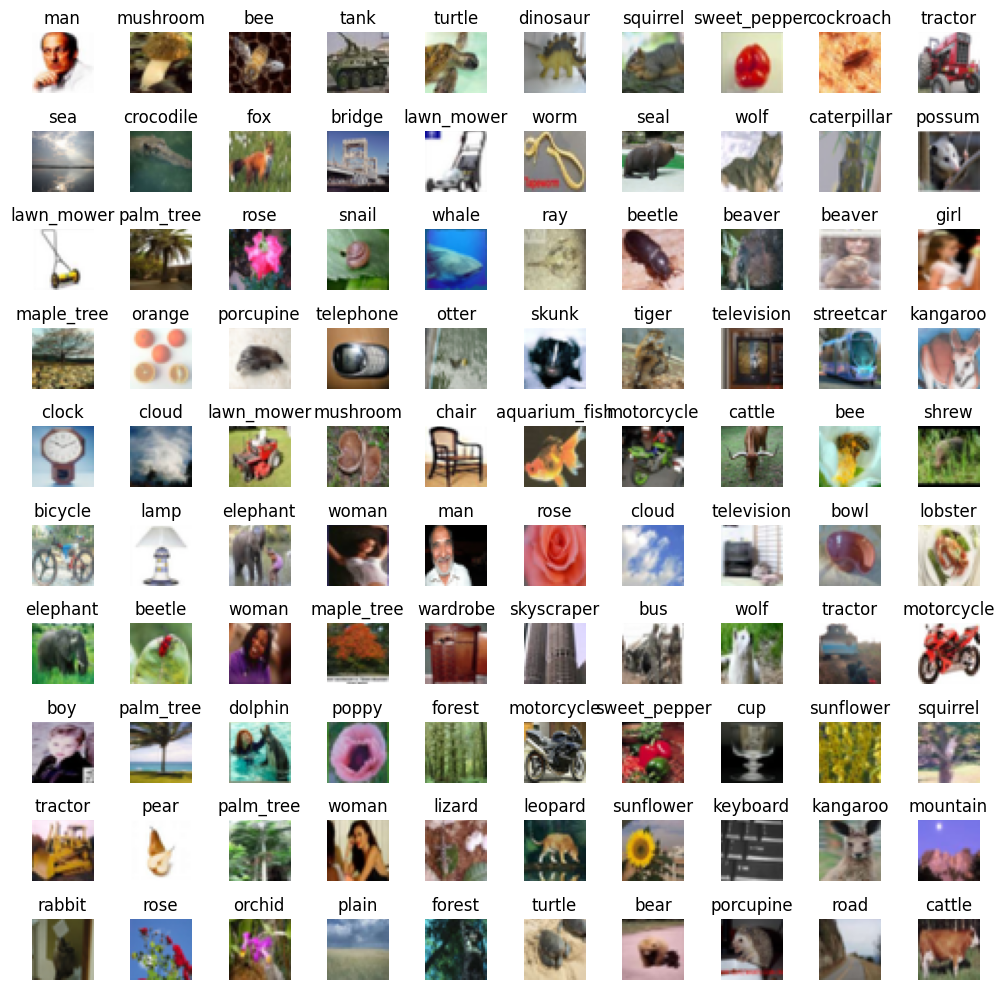

In [3]:
# Create a 10x10 subplot with random iamges and class mappings to observe our dataset

# Define the fine label names to get descriptive plots
fine_label_names = trainset.classes

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        idx = np.random.randint(0, 10000)
        img, label = trainset[idx]
        img = img / 2 + 0.5
        img = img.numpy().transpose(1, 2, 0)
        axs[i, j].imshow(img)
        axs[i, j].set_title(fine_label_names[label])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [4]:
from train_model import train_model

params = {
    'module__conv_channels': [32, 64],            # or try: [32, 64, 128]
    'module__fc_layers': [512],                   # or try: [512, 256]
    'module__dropout': 0.5,                        # or try: 0.3
    'lr': 0.001,                                  
    'batch_size': 32
}
# Train for 10 epochs using 1000 training samples (adjust as needed)
accuracy = train_model(params, num_epochs=10, n_training_samples=1000)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 101.73it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 100.91it/s]
Test Accuracy: 4.99%
